In [1]:
import pandas as pd
import numpy as np
from biopandas.pdb import PandasPdb
import os
import torch
import dgl
import dgl.function as fn
import networkx as nx
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

#### Read main files, exclude pication for now. We will use .psf files, so to make it simple we will substitute all pbd to psf.

In [2]:
data = pd.read_csv('data_sample/detailed_interaction.csv', 
                   usecols=['bond', 'distance', 'lig_atom_id', 'rec_atom_id', 'resnr', 'resnr_l', 'restype', 'restype_l', 'lig_coords', 'rec_coords', 'pdb'])

data.columns = ['bond', 'distance', 'lig_atom_id', 'lig_coords', 'rec_atom_id', 'rec_coords', 'resnr_bond', 'resnr_base', 'restype_bond', 'restype_base',  'pdb']



data.pdb = data.pdb.str.replace('pdb', 'psf')
files = data.pdb.unique()

data = data[(data.bond != 'pication')]

label_ = pd.read_csv('data_sample/affinity-toy.csv', usecols=['binding'])
label_ = label_.binding.apply(lambda row: 0 if row == 'Negative' else 1)

one_hot = False

#### Several service functions.

In [3]:
def add_mol_bonds(df_part, bond_type, psf_data, bonds_):
    """
    This functiuon reads a part of PSF file where it looks for information about connections inside the molecule of peptid and mhc.
    
    1. Get relevamt atom ids;
    2. Get only that part of PSF where we can find bonds;
    3. Make one vector with all bonds. Every pair of values (0-1: even-odd number) represent;
    4. Preprocessing of psf file;
    5. Save the vector with initial atom ids;
    6. Go through all initials:
        6.1. Check if our initial atom is in the bond vector;
        6.2. Based on the position take the neighbout from the left or from the right;
        6.3. Find distance between atoms;
    7. Make new df for appending.
    
    Input:
    1. DataFrame wot bonds;
    2. Type of molecule we a looking for: 'peptid' or 'mhc';
    3. PSF data file where we will find information about new bonds;
    
    Output:
    1. New df for appending
    """
    
    
    atoms = df_part.base.values 
    
    df_part.base_coords = df_part.base_coords.str.strip('()')
    df_part[['x', 'y', 'z']] = df_part['base_coords'].str.split(', ', expand=True).astype(float) 
    df_part = df_part.drop(['base_coords'], axis=1)

    psf = psf_data.loc[atoms]

    initials = psf.iloc[:,0].values
    
    bonds_left = bonds_[::2]
    bonds_two = np.vstack([bonds_left, bonds_[1::2]]).T
    bonds_two = bonds_two[np.isin(bonds_two[:,0], initials)]

    bonds = pd.DataFrame(bonds_two)
    
    initial_bonds = bonds.merge(psf.loc[:,0].reset_index(), on=0).merge(psf.loc[:,0].reset_index(),left_on=1, right_on=0).drop(['0_x', 1, '0_y'], axis=1)

    df_new = initial_bonds.merge(df_part, left_on='index_x', right_on='base').merge(df_part, left_on='index_y', right_on='base').drop(['index_x', 'index_y'], axis=1)


    df_new = initial_bonds.merge(df_part, left_on='index_x', right_on='base').merge(df_part, left_on='index_y', right_on='base').drop(['index_x', 'index_y'], axis=1)
    df_new['distance'] = ((df_new.x_x - df_new.x_y)**2 + (df_new.y_x - df_new.y_y)**2 + (df_new.z_x - df_new.z_y)**2).pow(1./2)
    df_new['bond_type'] = bond_type

    df_new.drop(['x_x', 'y_x', 'z_x', 'x_y', 'y_y', 'z_y'], axis=1, inplace=True)

    df_new.columns = ['base', 'resnr_base', 'restype_base', 'bond', 'resnr_bond', 'restype_bond', 'distance', 'bond_type']


    df_new = df_new.drop_duplicates(subset=['resnr_bond', 'resnr_base'], keep='first').reset_index()

    df_new = df_new[df_new['resnr_bond'] != df_new['resnr_base']]

    df_copy = df_new.copy()
    df_copy.base = df_new.bond
    df_copy.bond = df_new.base
    df_copy.resnr_base = df_new.resnr_bond
    df_copy.resnr_bond = df_new.resnr_base
    df_copy.restype_base = df_new.restype_bond
    df_copy.restype_bond = df_new.base

    df_new = df_new.append(df_copy)

    df_new = df_new.drop(['restype_bond', 'index'], axis=1)
        
    
    return df_new

In [4]:
def split_lig_rec(data):
    """
    This function parse such types of bonds as saltbridge and pistack
    
    Input:
    1. A part of df with all bonds.
    
    Output:
    1. New df where all saltbridge and pistack bonds are rewriten pair by pair.
    """
    ind = list()
    for i, (l, r)  in enumerate(zip(data.lig_atom_id, data.rec_atom_id)):
        
        lig_new = []
        rec_new = []
        lig_arr = np.array(l.strip('[]').split(','))
        rec_arr = np.array(r.strip('[]').split(','))
    
        if lig_arr.size+rec_arr.size > 2:
            for lig in range(lig_arr.size):
                for rec in range(rec_arr.size):
                    data = data.append({'bond':data.bond.iloc[i], 'distance':data.distance.iloc[i], 
                                                'lig_atom_id':lig_arr[lig], 'rec_atom_id':rec_arr[rec],
                                                'lig_coords':data.lig_coords.iloc[i],
                                                'rec_coords':data.rec_coords.iloc[i],
                                                'resnr_bond':data.resnr_bond.iloc[i],
                                                'resnr_base':data.resnr_base.iloc[i],
                                                'restype_bond': data.restype_bond.iloc[i],
                                                'restype_base': data.restype_base.iloc[i],
                                                'pdb':data.pdb.iloc[i]} , ignore_index=True)
            ind.append(i)
                    
    data = data.drop(np.array(ind))
    data = data.reset_index(drop=True)
        
    return data

#### The main part

In [5]:
all_A = []
label = []
# fix the order of bonds
bond_names = ['bond_saltbridge', 'bond_pistack', 'bond_hydroph_interaction', 'bond_covalent', 'bond_hbond']
acids = np.array(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HSD','ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP','TYR', 'VAL'])
file = ['000530._nmin.psf']
amino_prop = pd.read_csv("amino_acid_prop.csv")
amino_prop.rename(columns={'Unnamed: 0':'restype_base'}, inplace=True)
sc = StandardScaler()
amino_prop[amino_prop.drop('restype_base', axis=1).columns] = sc.fit_transform(amino_prop.drop('restype_base', axis=1))


for file in tqdm(files):
    
        #set label
    index = int(file.replace('_nmin.psf', ''))
    label.append(label_[index])

    #make a subset of the whole df
    df_ligand = data[data.pdb == file].copy()
    #parse saltbridge and pistack
    df_ligand = split_lig_rec(df_ligand)

    #read PSF file for this particular model
    skiprows=5+pd.read_csv("data_sample/models/" + file, delimiter=r"\s+", skiprows=2, nrows=1, header=None)[0].item()
    psf_data = pd.read_csv("data_sample/models/" + file, delimiter=r"\s+", skiprows=skiprows, header=None)
    
    #find the part with information about bonds
    start, end = np.where(psf_data.iloc[:, 1] == '!NBOND:')[0][0] + 1, np.where(psf_data.iloc[:, 1] == '!NTHETA:')[0][0] - np.where(psf_data.iloc[:, 1] == '!NBOND:')[0][0] - 1
    bonds_ = psf_data.iloc[start: start+end, :].drop(8, axis=1).fillna(-1).values.flatten()
    bonds_ = bonds_[bonds_!=-1].astype(int) #remove last several NaNs


    # remove H, chose only with atoms
    psf_data = psf_data[:start-1] #untill the start of the second part
    psf_data.iloc[:,4] = psf_data.iloc[:,4].str[0]
    psf_data = psf_data[psf_data.iloc[:,4] != 'H']
    psf_data = psf_data.reset_index(drop=True)
    psf_data.index += 1 # to deal with other numeration in detailed interaction
    
    
    #clean ids from brackets
    df_ligand.lig_atom_id = df_ligand.lig_atom_id.str.strip('[]').astype(int)
    df_ligand.rec_atom_id = df_ligand.rec_atom_id.str.strip('[]').astype(int)
    #rename columns for simplicity
    df_ligand.columns = ['bond_type', 'distance', 'base', 'base_coords', 'bond', 'bond_coords', 'resnr_bond', 'resnr_base', 'restype_bond', 'restype_base',  'file']
    
    #to make sure not to use 1 from mhs as peptid
    max_lig_amino = df_ligand.resnr_base.max()
    df_ligand.bond = df_ligand.bond + max_lig_amino

    #preparation for combining mhc-lehang connection
    df_mhc = df_ligand.copy()
    df_mhc.base_coords = df_ligand.bond_coords
    df_mhc.bond_coords = df_ligand.base_coords
    df_mhc.base = df_ligand.bond
    df_mhc.bond = df_ligand.base
    df_mhc.resnr_bond = df_ligand.resnr_base
    df_mhc.resnr_base = df_ligand.resnr_bond
    df_mhc.restype_bond = df_ligand.restype_base
    df_mhc.restype_base = df_ligand.restype_bond





    ###########
    ppdb = PandasPdb()
    pdb = ppdb.read_pdb('data_sample/models/' + file.split('.')[0] + '.pdb').df['ATOM']
    pdb = pdb[pdb.element_symbol != 'H'].reset_index(drop=True)
    pdb = pdb[pdb.chain_id == 'B']


    df_all_legands = pd.DataFrame(columns=['base', 'base_coords', 'resnr_base', 'restype_base'])
    df_all_legands.base = pdb.index + 1 #because in detailed interaction indexes are greater
    df_all_legands.base_coords = list(zip(pdb.x_coord, pdb.y_coord, pdb.z_coord))
    df_all_legands.base_coords = df_all_legands.base_coords.astype(str)

    df_all_legands.resnr_base = pdb.residue_number.values
    df_all_legands.restype_base = pdb.residue_name.values

    df = df_ligand.append(df_mhc)

    # append legand-legand and mhc-mhc information
    df = df.append(add_mol_bonds(df_all_legands, 'covalent', psf_data, bonds_))

    df.distance = df.distance.astype(float)

    df_amino = df.drop_duplicates(subset=['bond_type', 'resnr_bond', 'resnr_base'], keep='first').reset_index().drop(['index', 'base', 'bond', 'file', 'base_coords', 'restype_bond'], axis=1)

    df_amino.distance = df.groupby(['bond_type', 'resnr_bond', 'resnr_base']).distance.mean().values

    del df
    df = pd.merge(df_amino, amino_prop, on='restype_base' , how='inner')


    # code atom ids for usage in graphs
    base = df.resnr_base.astype('category').cat.codes.values
#     base = base - base.min() #get it to start from 0
    bond = df.resnr_bond.astype('category').cat.codes.values

    df.index = base
    df = df.sort_index()

    # edge features: type of bond (one-hot), distance
    edge_features = pd.DataFrame(0, index=df.index, columns=bond_names)
    bond_type = pd.get_dummies(df.bond_type, prefix='bond')
    edge_features[bond_type.columns] = bond_type
    edge_features.index = df.index
    distance = df.distance
    edge_features['distance'] = (distance - distance.mean())/distance.std()

    #     #test on the number of features
    #     if edge_features.shape[1] != 7:
    #         print('Error edge')
    #         break

        #the edge part is over, now we need to calculate gfeatures for nodes. first, drop duplicates
    df_unique = df.reset_index().drop_duplicates(subset='index', keep='first').drop('index', axis=1)
    df_unique.drop(['bond_type', 'bond_coords', 'distance', 'resnr_bond', 'resnr_base'], axis=1, inplace=True)
    
    if one_hot: 
        empty_acids = pd.DataFrame(0, index=df_unique.index, columns=acids)
        dummy = pd.get_dummies(df_unique.restype_base)
        empty_acids[dummy.columns] = dummy
        node_features = df_unique.join(empty_acids).drop('restype_base', axis=1)
    else:
        node_features = df_unique.drop('restype_base', axis=1)

#     if sum(bond < 0) + sum(base < 0):
#         print("ERROR with category encoding")
#     if bond.max() != base.max():
#         print("ERROR with max value of base/bond")

    #make a graph
    num_nodes = base.max()
    G = dgl.DGLGraph()
    G.add_nodes(int(num_nodes+1))
    G.add_edges(base, bond)
    G.ndata['h'] = torch.tensor(node_features.values)
    G.edata['h'] = torch.tensor(edge_features.values)
    all_A.append(G)

# #     if line > 0:
# #         break

100%|██████████| 995/995 [05:09<00:00,  2.80it/s]


#### Bellow there is one of graph representation: kamada_kawai_layout

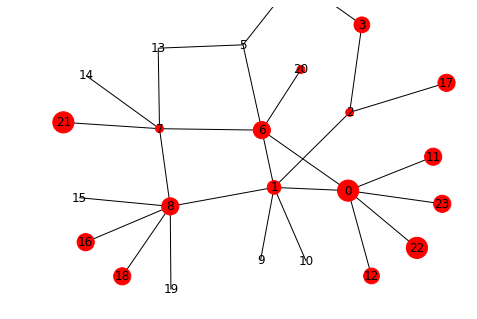

In [8]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_size=node_features.mass*200, )
# nx.draw_networkx_nodes(nx_G, pos, node_size=node_features.mass.values)
# nx.draw_networkx(nx_G, pos, node_size=node_features.mass.values*200)

In [15]:
G = all_A[-400]

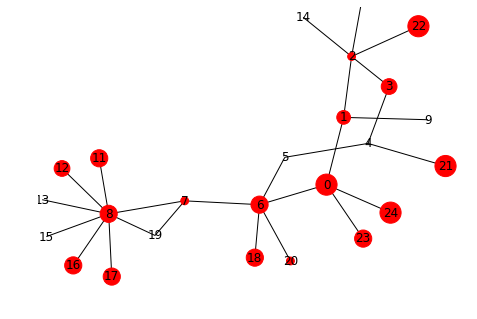

In [16]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_size=node_features.mass.values*200)
# nx.draw_networkx_nodes(nx_G, pos, node_size=node_features.mass.values)
# nx.draw_networkx(nx_G, pos, node_size=node_features.mass.values*200)

In [7]:
import pickle

with open('graphs_amino_small.pickle', 'wb') as gr:
    pickle.dump(all_A, gr, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('lables_amino_small.pickle', 'wb') as la:
    pickle.dump(label, la, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
G

DGLGraph(num_nodes=24, num_edges=62,
         ndata_schemes={'h': Scheme(shape=(11,), dtype=torch.float64)}
         edata_schemes={'h': Scheme(shape=(6,), dtype=torch.float64)})